In [169]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch
import matplotlib.pyplot as plt

### Read in data

In [170]:
data2009 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2009.csv")
data2010 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2010.csv")
data2011 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2011.csv")
data2012 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2012.csv")
data2013 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2013.csv")
data2014 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2014.csv")
data2015 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2015.csv")
# data2016 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2016.csv")
# data2017 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2017.csv")
# data2018 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2018.csv")
# data2019 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2019.csv")

C:\Users\Laptop\AppData\Local\Temp\ipykernel_4360\3271149568.py:1: DtypeWarning: Columns (42,167,168,175,176,179,180,183,184,189,190,191,192,204,205,206,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  data2009 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2009.csv")
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4360\3271149568.py:2: DtypeWarning: Columns (42,167,168,169,170,175,176,179,180,183,184,189,190,191,192,195,196,204,205,206,219,220,221,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  data2010 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2010.csv")
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4360\3271149568.py:3: DtypeWarning: Columns (37,38,39,42,46,47,167,168,169,170,173,174,175,176,177,178,179,180,183,184,185,186,189,190,191,192,193,194,195,196,199,200,204,205,206,225,226,227,228,232,233,23

In [171]:
data = data2009.append(data2010)
data = data.append(data2011)
data = data.append(data2012)
data = data.append(data2013)
data = data.append(data2014)
# data = data.append(data2015)
# data = data.append(data2016)
# data = data.append(data2017)
# data = data.append(data2018)
# data = data.append(data2019)

C:\Users\Laptop\AppData\Local\Temp\ipykernel_4360\3244673017.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data2009.append(data2010)
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4360\3244673017.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data2011)
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4360\3244673017.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data2012)
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4360\3244673017.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data2013)
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4360\3244673017.py:5: Futur

### Preprocessing and Creating Final Score Outcome Variable

In [172]:
def preprocessing(data):
    # Create a new column called 'final_score' and initialize it with NaN values
    data['home_final_score'] = float('nan')
    data['away_final_score'] = float('nan')

    # Loop through each game in the data
    for game_id in data['game_id'].unique():
        # Get the subset of data for the current game
        game_df = data[data['game_id'] == game_id]

        # Get the final score for the game (which should be the score of the last observation)
        home_final_score = game_df.iloc[-1]['total_home_score']
        away_final_score = game_df.iloc[-1]['total_away_score']

        # Set the 'final_score' column for all rows in this game to be the final score
        data.loc[data['game_id'] == game_id, 'home_final_score'] = home_final_score
        data.loc[data['game_id'] == game_id, 'away_final_score'] = away_final_score
        
    data['home_differential'] = data['home_final_score']-data['away_final_score']
    
    data = data[['game_id','home_team', 'away_team', 'posteam_type', 'yardline_100', 'quarter_seconds_remaining', 
                     'half_seconds_remaining', 'game_seconds_remaining', 'drive', 'down', 'ydstogo', 'no_huddle', 
                     'home_timeouts_remaining', 'away_timeouts_remaining', 'score_differential_post', 
                     'total_home_rush_epa','total_away_rush_epa', 'total_home_pass_epa','total_away_pass_epa',
                     'score_differential_post', 'total_home_score', 'total_away_score', 'home_differential']]

    data = data.dropna()
    
    data['home_team'] = data['home_team'].astype(str)
    data['away_team'] = data['away_team'].astype(str)
    data['posteam_type'] = data['posteam_type'].astype(str)
    
    df = data

    categorical_vars = ['home_team', 'away_team', 'posteam_type', 'no_huddle']
    numerical_vars = ['yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining',
                  'drive', 'down', 'ydstogo', 'home_timeouts_remaining', 'away_timeouts_remaining',
                  'score_differential_post', 'total_home_rush_epa', 'total_away_rush_epa', 'total_home_pass_epa',
                  'total_away_pass_epa', 'total_home_score', 'total_away_score']

    # One-hot encode the categorical variables
    ohe = OneHotEncoder(sparse=False)
    categorical_data = ohe.fit_transform(df[categorical_vars])

    # Standardize the numerical variables
    scaler = StandardScaler()
    numerical_data = scaler.fit_transform(df[numerical_vars])

    # Combine the categorical and numerical data into a single array
    X = np.concatenate((categorical_data, numerical_data), axis=1)
    X = np.asarray(X).astype('float32')

    # Split the data into training and testing sets
    y = df['home_differential']
    return X, y

### Create Subset of halftime plays

In [173]:
testing = data2012
half_time = testing[(testing['game_seconds_remaining'] > 1800) & (testing['game_seconds_remaining'] < 1810)]
training = data

### Create Training and testing data

In [174]:
X_test_half, y_test_half = preprocessing(half_time)
X_test_full, y_test_full = preprocessing(testing)
X_train, y_train = preprocessing(training)

C:\Users\Laptop\AppData\Local\Temp\ipykernel_4360\3344466308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['home_final_score'] = float('nan')
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4360\3344466308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['away_final_score'] = float('nan')
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4360\3344466308.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

### Define network architecture

In [175]:
# Reshape the data to be 3D with the number of time steps (i.e., plays)
n_time_steps = 1
n_features = X_train.shape[1]
X_train = X_train.reshape((X_train.shape[0], 1,  X_train.shape[1]))
X_test_half = X_test_half.reshape((X_test_half.shape[0], 1, X_test_half.shape[1]))
X_test_full = X_test_full.reshape((X_test_full.shape[0], 1, X_test_full.shape[1]))
# X_test_q1 = X_test_q1.reshape((X_test_q1.shape[0], 1, X_test_q1.shape[1]))
# X_test_q3 = X_test_q3.reshape((X_test_q3.shape[0], 1, X_test_q3.shape[1]))


# Define the LSTM model

model = tf.keras.Sequential([
    LSTM(128, return_sequences = True, input_shape=(n_time_steps, n_features)),
    LSTM(64, return_sequences = True),
    LSTM(32, return_sequences = True),
    LSTM(16, return_sequences = True),
    LSTM(8, return_sequences = True),
    Dense(1)
])


optimize = tf.keras.optimizers.Adam(learning_rate=0.05)
# Compile the model
model.compile(loss='mean_squared_error', optimizer=optimize)

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=154)

# Evaluate the model on the testing data
rmse_half = np.sqrt(model.evaluate(X_test_half, y_test_half))
rmse_full = np.sqrt(model.evaluate(X_test_full, y_test_full))

print(f"Root Mean Squared Error Half: {rmse_half}")
print(f"Root Mean Squared Error Full: {rmse_full}")

Epoch 1/5
1496/1496 [==============================] - 36s 17ms/step - loss: 110.4245
Epoch 2/5
1496/1496 [==============================] - 33s 22ms/step - loss: 84.7839
Epoch 3/5
1496/1496 [==============================] - 32s 22ms/step - loss: 76.9671
Epoch 4/5
1496/1496 [==============================] - 33s 22ms/step - loss: 70.0677
Epoch 5/5
1210/1210 [==============================] - 5s 4ms/step - loss: 62.9919
Root Mean Squared Error Half: 7.209359803367707
Root Mean Squared Error Full: 7.936743272168412


In [176]:
preds_half = model.predict(X_test_half)
preds_full = model.predict(X_test_full)
x_half = np.linspace(0,100,100)
x_full = np.linspace(0, 750, 750)

1210/1210 [==============================] - 7s 5ms/step


ValueError: x and y can be no greater than 2D, but have shapes (100,) and (100, 1, 1)

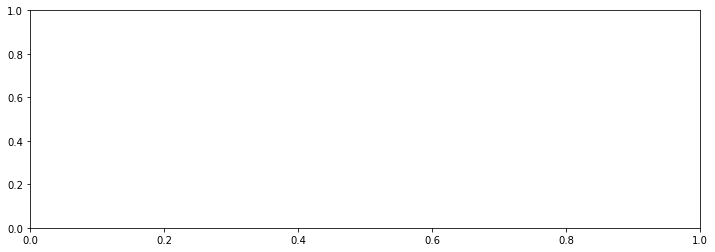

In [177]:
plt.figure(figsize=(12,4))
plt.plot(x_half, preds_half[0:100], label = "Predicted Differential")
plt.plot(x_half, y_test_half[0:100], label = "True Differential")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(x_full, preds_full[0:750], label = "Predicted Differential")
plt.plot(x_full, y_test_full[0:750], label = "True Differential")
plt.legend()
plt.show()